## Imports

In [1]:
%matplotlib inline
import sys, os
import numpy as np
import pyemma as pe
import pyemma
import torch  # pytorch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import mdtraj

import yaml

In [2]:
sys.path.insert(0,'../')
from torchmdnet2.dataset import ChignolinDataset, DataModule
from torchmdnet2.models import LNNP, SchNet, MLPModel, CGnet
from torchmdnet2.utils import LoadFromFile, save_argparse
from torchmdnet2.simulation import Simulation

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

from pytorch_lightning.plugins import DDPPlugin

from torch_geometric.data import DataLoader

from torch.nn import Embedding, Sequential, Linear, ModuleList

In [3]:
device = torch.device('cuda')

## Utils

In [4]:
def plot_tica(baseline_model, dataset, lag=10, tica=None):
    # compute distances all of the beads
    baseline_model.cpu()  # moves the tensors onto the cpu
    if isinstance(dataset, np.ndarray):  # check if the dataset is an numpy array
        n_traj, n_samp, n_beads, _ = dataset.shape
        features = []
        for i_traj in range(n_traj):
            _ = baseline_model.geom_feature(torch.from_numpy(dataset[i_traj]))
            feat = baseline_model.geom_feature.distances
            features.append(feat)
    else:
        _ = baseline_model.geom_feature(dataset.data.pos.reshape((-1, baseline_model.n_beads, 3)))
        feat = baseline_model.geom_feature.distances

        if 'traj_idx' in dataset.data:
            traj_ids = dataset.data.traj_idx
            n_traj = np.unique(traj_ids).shape[0]
            traj_strides = np.cumsum([0]+(np.bincount(traj_ids)).tolist(), dtype=int)

            features = []
            for i_traj in range(n_traj):
                st, nd = traj_strides[i_traj], traj_strides[i_traj+1]
                features.append(feat[st:nd].numpy())
        else:
            features = feat.numpy()
            
    if tica is None:
        tica = pe.coordinates.tica(features, lag=lag, dim=2)
        tica_concatenated = np.concatenate(tica.get_output())
    else:
        Xproj = tica.transform(features)
        tica_concatenated = np.concatenate(Xproj)

    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    pyemma.plots.plot_feature_histograms(
        tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
    pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
    pyemma.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False)
    for ax in axes.flat[1:]:
        ax.set_xlabel('IC 1')
        ax.set_ylabel('IC 2')
    fig.tight_layout()
    return fig, axes, tica

In [5]:
def plot_tica2(baseline_model, dataset, tica, rows=1, columns=3, start=0):
    # compute distances all of the beads
    baseline_model.cpu()  # moves the tensors onto the cpu
    
    n_traj, n_samp, n_beads, _ = dataset.shape
    features = []
    for i_traj in range(n_traj):
        _ = baseline_model.geom_feature(torch.from_numpy(dataset[i_traj]))
        feat = baseline_model.geom_feature.distances
        features.append(feat)
            
    Xproj = tica.transform(features)
    tica_concatenated = np.concatenate(Xproj)
    
    
    xxx = np.zeros((len(dataset[:,0,0]), len(dataset[0,:,0])))
    yyy = np.zeros((len(dataset[:,0,0]), len(dataset[0,:,0])))
    
    for i in range(len(dataset[:,0,0])):  # len = number of simulations
        for j in range(len(dataset[0,:,0])):  # len = number of timesteps
            xxx[i, j] = Xproj[i][j][0]
            yyy[i, j] = Xproj[i][j][1]
    
    fig, axes = plt.subplots(rows, columns, figsize=(12, 10))

    counter = 0            
        
    for ax in axes.flat:
        pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax, cbar=False, logscale=True)
        
        ax.plot(xxx[start+counter], yyy[start+counter], color="white")
        ax.set_title(f"Trajectory {start+counter}")
        
        ax.set_xlabel('IC 1')
        ax.set_ylabel('IC 2')
        counter += 1
    fig.tight_layout()
    return fig, axes, tica

In [6]:
from torch_geometric.data.data import size_repr

from argparse import Namespace
class Args(Namespace):
    def __init__(self,**kwargs):
        for key, item in kwargs.items():
            self[key] = item
            
    def __getitem__(self, key):
        r"""Gets the data of the attribute :obj:`key`."""
        return getattr(self, key, None)

    def __setitem__(self, key, value):
        """Sets the attribute :obj:`key` to :obj:`value`."""
        setattr(self, key, value)

    @property
    def keys(self):
        r"""Returns all names of graph attributes."""
        keys = [key for key in self.__dict__.keys() if self[key] is not None]
        keys = [key for key in keys if key[:2] != '__' and key[-2:] != '__']
        return keys

    def __len__(self):
        r"""Returns the number of all present attributes."""
        return len(self.keys)

    def __contains__(self, key):
        r"""Returns :obj:`True`, if the attribute :obj:`key` is present in the
        data."""
        return key in self.keys

    def __iter__(self):
        r"""Iterates over all present attributes in the data, yielding their
        attribute names and content."""
        for key in sorted(self.keys):
            yield key, self[key]

    def __call__(self, *keys):
        r"""Iterates over all attributes :obj:`*keys` in the data, yielding
        their attribute names and content.
        If :obj:`*keys` is not given this method will iterative over all
        present attributes."""
        for key in sorted(self.keys) if not keys else keys:
            if key in self:
                yield key, self[key]
                
    def __repr__(self):
        cls = str(self.__class__.__name__)
        has_dict = any([isinstance(item, dict) for _, item in self])

        if not has_dict:
            info = [size_repr(key, item) for key, item in self]
            return '{}({})'.format(cls, ', '.join(info))
        else:
            info = [size_repr(key, item, indent=2) for key, item in self]
            return '{}(\n{}\n)'.format(cls, ',\n'.join(info))

In [17]:
def parameterfinder(location, spectrum, traj):
    dic = yaml.safe_load(open(rf'{location}'))
    
    if spectrum == "rs":
        max_radial = dic["model"]["calculator"]["init_args"]["max_radial"]
        interaction_cutoff = dic["model"]["calculator"]["init_args"]["interaction_cutoff"]
        train_stride = dic["data"]["train_stride"]
        time_steps = len(traj[0,:,0])
        simulations = len(traj[:,0,0])
        
        print(f"max_radial = {max_radial}, interaction_cutoff = {interaction_cutoff}, train_stride = {train_stride}")
        print(f"n_simulations = {simulations}, time_steps = {time_steps}")
        
    if spectrum == "ps":
        max_radial = dic["model"]["calculator"]["init_args"]["max_radial"]
        max_angular = dic["model"]["calculator"]["init_args"]["max_angular"]
        interaction_cutoff = dic["model"]["calculator"]["init_args"]["interaction_cutoff"]
        train_stride = dic["data"]["train_stride"]
        time_steps = len(traj[0,:,0]) * 10
        simulations = len(traj[:,0,0])     
              
        print(f"max_radial = {max_radial}, max_angular = {max_angular}, interaction_cutoff = {interaction_cutoff}, train_stride = {train_stride}")
        print(f"n_simulations = {simulations}, time_steps = {time_steps}")
              
    return

## All atom simulation

In [8]:
# this cell has to be executed before the coarse grained tica plots can be made
chignolin_dataset = ChignolinDataset('/local_scratch/hoffmae99/bachelor/datasets/chignolin/')
baseline_model = chignolin_dataset.get_baseline_model(n_beads=10)  # doesn't work without specifying n_beads

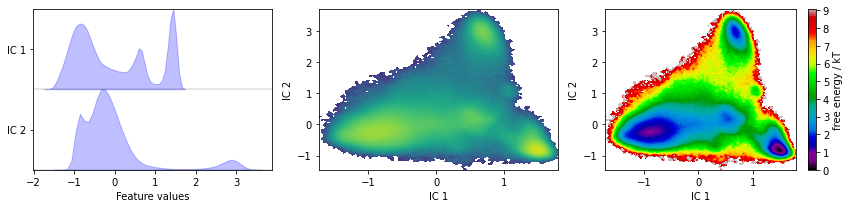

In [9]:
_,_, tica = plot_tica(baseline_model, chignolin_dataset, lag=10)

## CGSchNet

n_simulations = 1001, time_steps = 1000


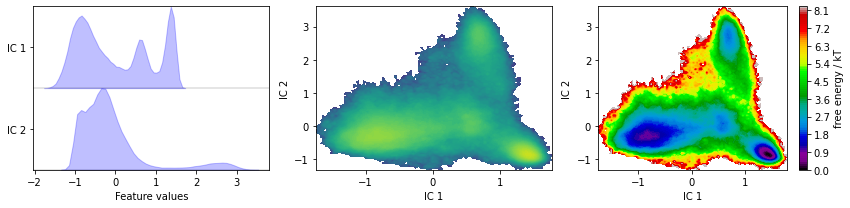

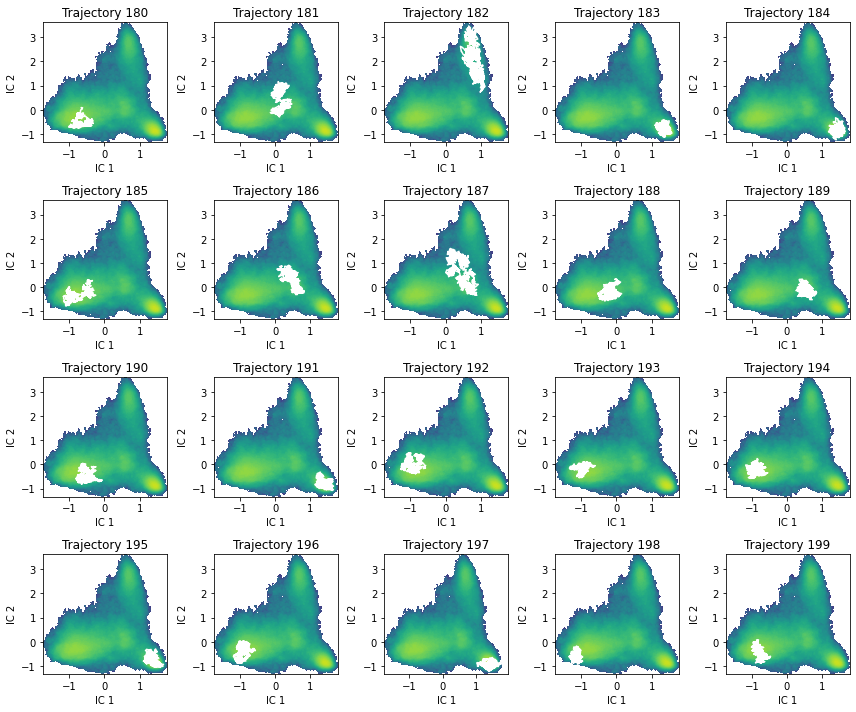

In [10]:
# this trained with the same parameters as in the paper
traj_cgschnet = np.load('/local_scratch/hoffmae99/bachelor/chign/test_0/traj.npy')

print(f"n_simulations = {len(traj_cgschnet[:,0,0])}, time_steps = {len(traj_cgschnet[0,:,0])}")

_,_,_ = plot_tica(baseline_model, traj_cgschnet, tica=tica)
_,_,_ = plot_tica2(baseline_model, traj_cgschnet, tica=tica, rows=4, columns=5, start=180)

## Radial Spectrum

max_radial = 10, interaction_cutoff = 15, train_stride = 1
n_simulations = 201, time_steps = 1236


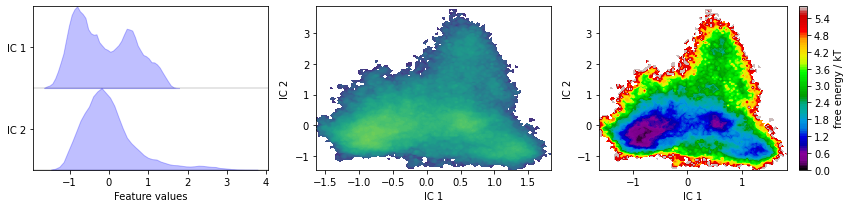

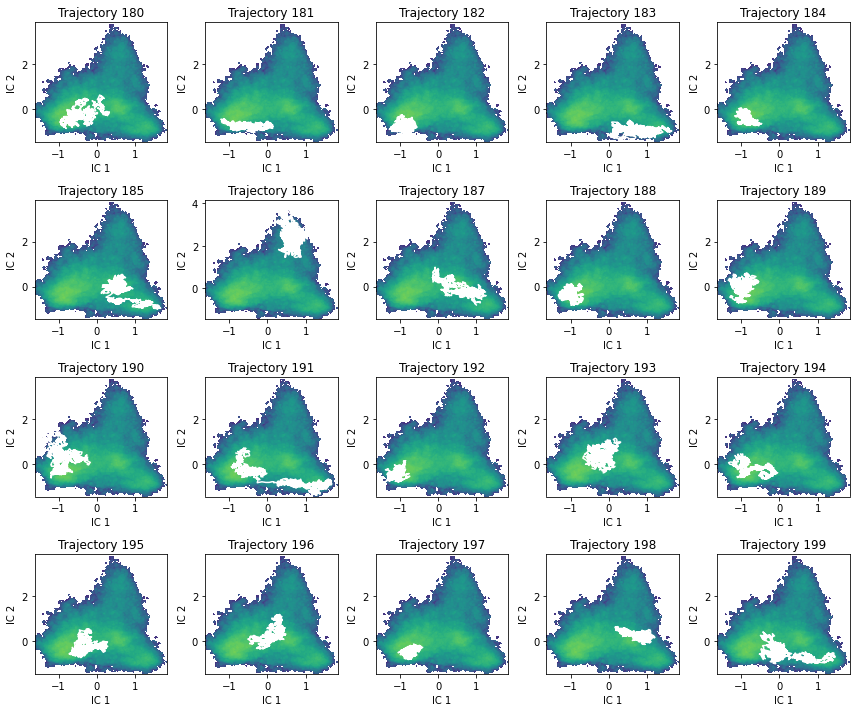

In [16]:
traj_rs = np.load('/local_scratch/hoffmae99/bachelor/chign/radial/test_0/traj1.npy')  # only 201 simulations, not 1001
# traj_rs = traj_rs[:, :1000]

parameterfinder("/local_scratch/hoffmae99/bachelor/chign/radial/test_0/config.yaml", "rs", traj_rs)

_,_,_ = plot_tica(baseline_model, traj_rs, tica=tica)
_,_,_ = plot_tica2(baseline_model, traj_rs, tica=tica, rows=4, columns=5, start=180)

## Power Spectrum

### max_radial: 10 max_angular: 0 interaction_cutoff: 15.0

max_radial = 10, max_angular = 0, interaction_cutoff = 15.0, train_stride = 10
n_simulations = 1001, time_steps = 1500


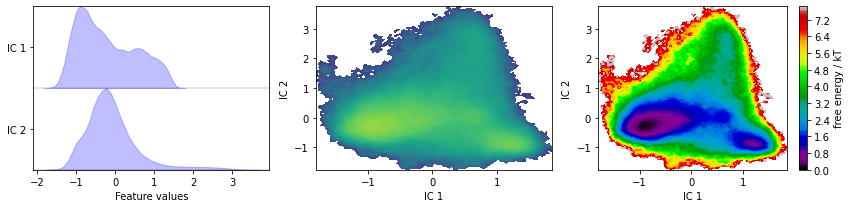

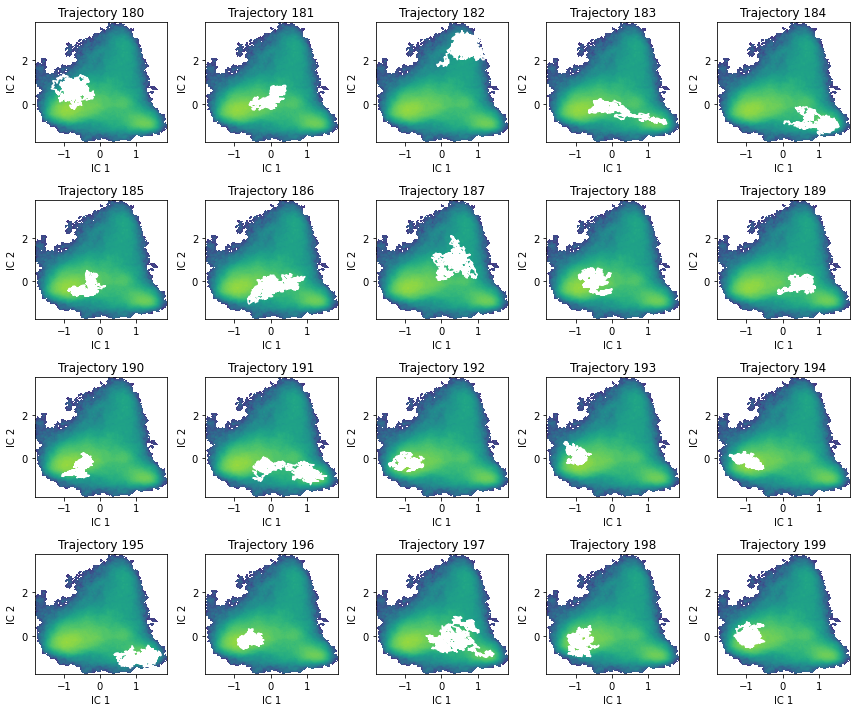

In [12]:
traj_ps5 = np.load('/local_scratch/hoffmae99/bachelor/chign/test_5/traj.npy')
traj_ps5 = traj_ps5[:, :1500]

parameterfinder("/local_scratch/hoffmae99/bachelor/chign/test_5/config.yaml", "ps", traj_ps5)

_,_,_ = plot_tica(baseline_model, traj_ps5, tica=tica)
_,_,_ = plot_tica2(baseline_model, traj_ps5, tica=tica, rows=4, columns=5, start=180)

### max_radial: 10 max_angular: 3 interaction_cutoff: 15.0

max_radial = 10, max_angular = 3, interaction_cutoff = 15.0, train_stride = 1
n_simulations = 1001, time_steps = 1000


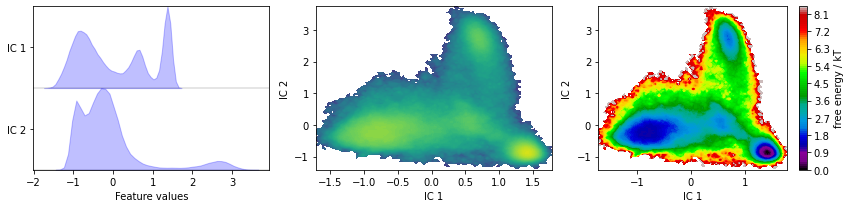

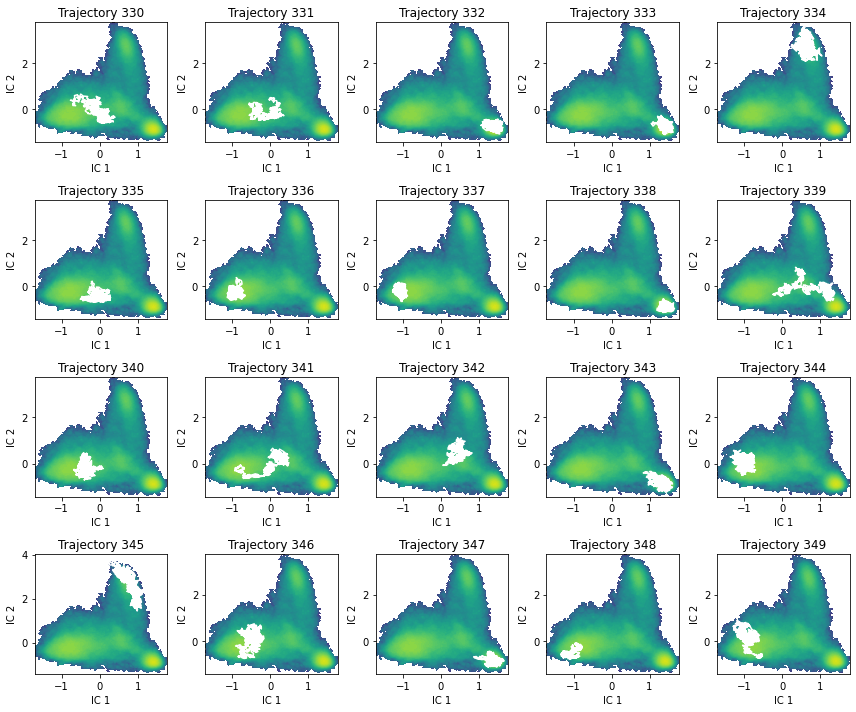

In [15]:
traj_ps4 = np.load('/local_scratch/hoffmae99/bachelor/chign/test_4/traj.npy')

parameterfinder("/local_scratch/hoffmae99/bachelor/chign/test_4/config.yaml", "ps", traj_ps4)

_,_,_ = plot_tica(baseline_model, traj_ps4, tica=tica)
_,_,_ = plot_tica2(baseline_model, traj_ps4, tica=tica, rows=4, columns=5, start=330)